<a href="https://colab.research.google.com/github/sohiniroych/AI_with_Sohini_Notebooks/blob/main/Sample_Imbalance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This work is motivated by the publication https://arxiv.org/pdf/2010.02503.pdf

This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the csv data and figures in the same Google Drive folder as this notebook.

## The first step is to convert session level information to User-journey level data, i.e. track time stamps from a particulat userID-Product ID combination over time to see if the combination results in a purchase (Y=1) or not (Y=0). The user journey level features extracted for this data set looks as follows:

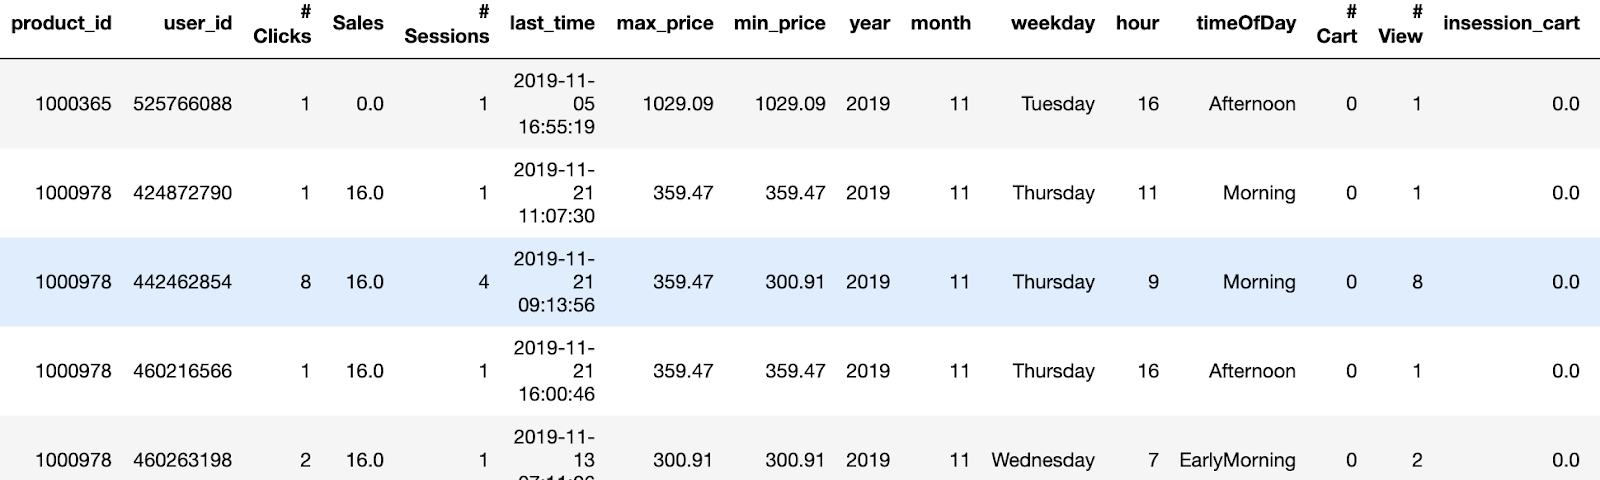

In [ ]:
Image(filename='image10.png')

## You have access to user journey level data. Your goal is to perform the following:
## A. To identify what features are most important to classify purchasing customers from non-purchasing customers
## B. To predict a purchasing customer-product interaction from a no-purchasing one. The goal is to build the "best" data model with regards to Recall and F1-score.

## Task 0 (Initialization): Understand the Data!

In [1]:
## Importing required Libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#@title First, we connect to GDrive containing data and migrate to subfolder containing the data. Please modify the path and then run this cell.
# First lets connect the Gdrive that contains the data
from google.colab import drive
drive.mount('/content/drive')
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it based on your path!
os.chdir('/content/drive/MyDrive/Colab Notebooks/Lecture_series/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in the training data, print its shape, and display its first few rows

In [3]:

df = pd.read_csv("Walmart_bath_data_2022.csv")
print(df.shape)
df.head()


(250000, 36)


user_id  product_id  NumOfEventsInJourney  NumSessions  interactionTime  \
0  537190108       27762                     2            2             4749   
1  577668451     5865119                     1            1                0   
2  607369766     5922121                     1            1                0   
3  572456715     5723529                     1            1                0   
4  566667766     5823646                     1            1                0   

   maxPrice  minPrice  NumCart  NumView  NumRemove  ...  Nov  Dec  Afternoon  \
0     19.03     19.03        0        1          1  ...    1    0          0   
1      4.60      4.60        0        1          0  ...    1    0          1   
2     35.71     35.71        0        1          0  ...    0    0          0   
3      2.94      2.94        1        0          0  ...    1    0          0   
4      5.22      5.22        0        1          0  ...    0    0          0   

   Dawn  EarlyMorning  Evening  Morning  Night  Noon  Purchase  
0     0             0        0        1      0     0         0  
1     0             0        0        0      0     0         0  
2     0             0        1        0      0     0         0  
3     0             1        0        0      0     0         0  
4     0             0        1        0      0     0         0  

[5 rows x 36 columns]

## Data Wrangling!

### Find the non-numeric features

In [4]:

df.describe()


user_id    product_id  NumOfEventsInJourney   NumSessions  \
count  2.500000e+05  2.500000e+05         250000.000000  250000.00000   
mean   5.267921e+08  5.463843e+06              2.040140       1.36618   
std    8.613435e+07  1.346599e+06              2.144525       1.11341   
min    1.120748e+06  3.752000e+03              1.000000       1.00000   
25%    4.923112e+08  5.724604e+06              1.000000       1.00000   
50%    5.571986e+08  5.810903e+06              1.000000       1.00000   
75%    5.832883e+08  5.859081e+06              2.000000       1.00000   
max    6.220850e+08  5.932585e+06            178.000000     159.00000   

       interactionTime       maxPrice       minPrice        NumCart  \
count     2.500000e+05  250000.000000  250000.000000  250000.000000   
mean      2.755043e+05       9.736270       9.710410       0.569296   
std       1.085577e+06      21.713347      21.690626       1.062692   
min       0.000000e+00       0.000000       0.000000       0.000000   
25%       0.000000e+00       2.370000       2.370000       0.000000   
50%       0.000000e+00       4.435000       4.370000       0.000000   
75%       2.268000e+03       7.860000       7.860000       1.000000   
max       1.307107e+07     327.780000     327.780000     120.000000   

             NumView      NumRemove  ...            Nov            Dec  \
count  250000.000000  250000.000000  ...  250000.000000  250000.000000   
mean        0.952296       0.391980  ...       0.214408       0.172808   
std         1.386035       0.898425  ...       0.410412       0.378082   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         1.000000       0.000000  ...       0.000000       0.000000   
75%         1.000000       0.000000  ...       0.000000       0.000000   
max       178.000000      67.000000  ...       1.000000       1.000000   

           Afternoon           Dawn   EarlyMorning        Evening  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean        0.217956       0.059956       0.167116       0.242732   
std         0.412858       0.237406       0.373080       0.428735   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             Morning          Night           Noon       Purchase  
count  250000.000000  250000.000000  250000.000000  250000.000000  
mean        0.172272       0.078860       0.061108       0.120684  
std         0.377617       0.269521       0.239529       0.325760  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 36 columns]

### Determine the fractions of user journeys which result in purchases in both the training and test datasets. Are the datasets balanced?

In [29]:
# Extract the 'Purchase' columns of the datasets as your targets
y= df.iloc[:,-1]
X=df.iloc[:,0:-1]
# You can change the wording of the print() commands from "Percentage" to "Fraction" if you prefer
print(f'Percentage of purchases in the data = {(np.sum(y)*100)/len(y)}') 

Percentage of purchases in the data = 12.0684


In [30]:
# Next, split the data to train and test 70/30 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Task 1: To find the optimal set of features for this data set. Visualize each feature's contribution to separate Purchase=0 from Purchase=1, and select the top two features (for scatter plot)
    

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
print(f'The training data currently has {X_train.shape[1]} features')

The training data currently has 35 features


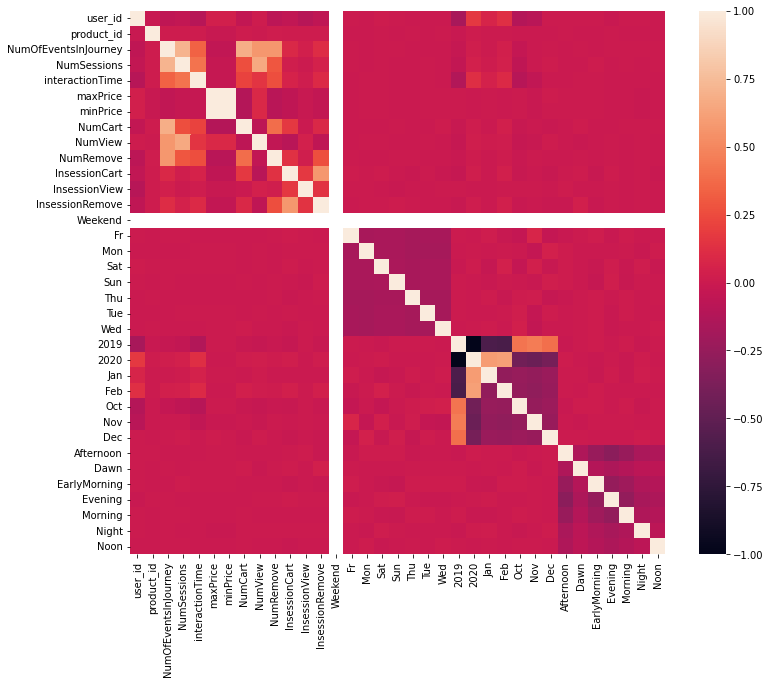

In [12]:
#Visual inspection of features
plt.figure(figsize=(12,10))
# Compute the Pearson Correlation of each feature in the training df
cor = X_train.corr()
# Plot the correlations
sns.heatmap(cor)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

### Fill (replace) NaN values in the correlation matrix with 1 so the associated features (with no variance) can be removed

In [13]:

cor = cor.fillna(0)


### Drop features with high correlations

In [14]:
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = np.full((cor.shape[0],), True, dtype=bool)
# Loop over all columns
for i in range(cor.shape[0]-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1, cor.shape[0]-1):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8, or no correlation 0 value...
        if (np.abs(cor.iloc[i,j]) >= 0.8):
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[j]:
                # Drop column j
                keep_columns[j] = False
# Extract the columns to keep from the training df
selected_columns = X_train.columns[keep_columns]
# Make a new df with the columns we've decided to keep from the training df
X_out = X_train[selected_columns]

print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print(y_train.shape)
X_out.head()

The following columns are present in the new data:
Index(['user_id', 'product_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'NumCart', 'NumView', 'NumRemove',
       'InsessionCart', 'InsessionView', 'InsessionRemove', 'Weekend', 'Fr',
       'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019', 'Jan', 'Feb', 'Oct',
       'Nov', 'Dec', 'Afternoon', 'Dawn', 'EarlyMorning', 'Evening', 'Morning',
       'Night', 'Noon'],
      dtype='object')
The old data had 35 features. The new df has 33 features.
(175000,)


user_id  product_id  NumOfEventsInJourney  NumSessions  \
192448  548456222     5773605                     5            4   
139604  559383497     5711089                     1            1   
140914  572502614     5645062                     1            1   
80088   511210947     5898985                     5            1   
72918   568121364     5815653                     1            1   

        interactionTime  maxPrice  NumCart  NumView  NumRemove  InsessionCart  \
192448          7554891      1.90        3        0          0             35   
139604                0      3.62        0        1          0             25   
140914                0     30.16        0        1          0              0   
80088               108     11.00        2        1          1              2   
72918                 0      0.67        1        0          0             13   

        ...  Oct  Nov  Dec  Afternoon  Dawn  EarlyMorning  Evening  Morning  \
192448  ...    0    0    0          0     0             0        0        1   
139604  ...    1    0    0          0     0             1        0        0   
140914  ...    0    1    0          0     0             0        0        1   
80088   ...    0    0    1          0     0             0        0        1   
72918   ...    0    1    0          0     0             0        0        1   

        Night  Noon  
192448      0     0  
139604      0     0  
140914      0     0  
80088       0     0  
72918       0     0  

[5 rows x 33 columns]

### Feature Selection on p-value (statistical significance to Y value)

In [15]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(X_out.values, y_train, SL, selected_columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
Index(['user_id', 'NumOfEventsInJourney', 'NumSessions', 'interactionTime',
       'maxPrice', 'NumCart', 'NumView', 'NumRemove', 'InsessionCart',
       'InsessionView', 'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue',
       'Wed', '2019', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon'],
      dtype='object')
After selection by Pearson Correlation, we had 33 features.
After selection by p-value, we have 31 features.


In [32]:
X_test_red=X_test.loc[:, X_test.columns.isin(list(selected_columns))]

In [19]:
data_red['Purchase']=y_train

In [21]:
import warnings
warnings.filterwarnings('ignore')

### Visualize the selected features

Ignore the warning messages about distplot. I should replace it with displot, but I haven't figured out how to overlay plots with it.

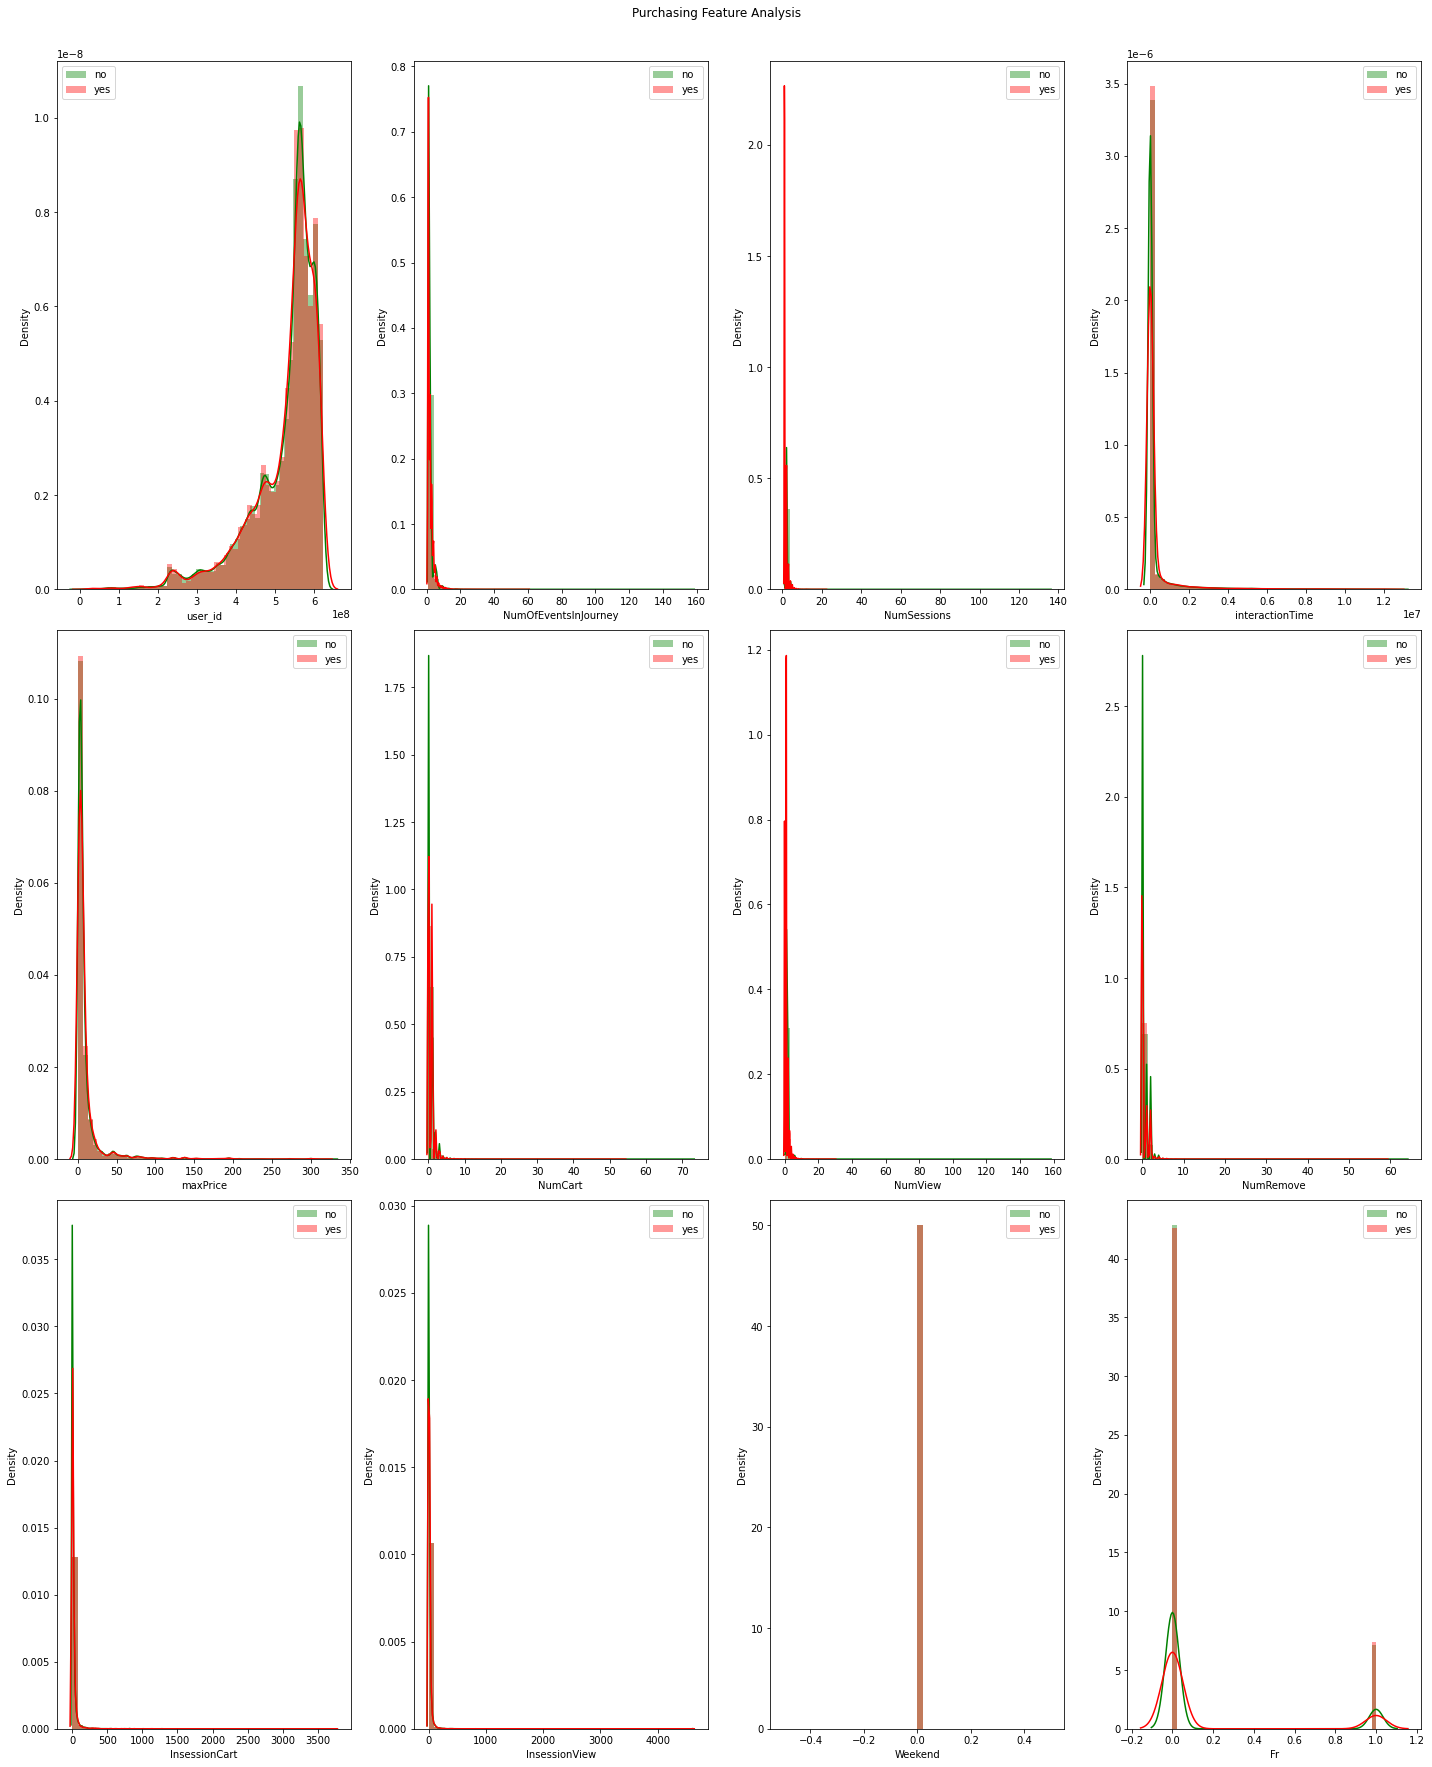

In [22]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns[0:12]:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(data_red[i][data_red['Purchase']==0], color='g', label = 'no')
    sns.distplot(data_red[i][data_red['Purchase']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Purchasing Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Drop purchase from the features of X_train and X_test and scale the features so the max norm of each feature is 1. Also, convert the X DataFrames and y Series to NumPy arrays for use with the visualization convenience function which we'll set up next.

In [33]:
from sklearn.preprocessing import normalize
# Note that this function outputs NumPy arrays by default
X_train = data_red.drop(columns='Purchase')
#X_train = X_train / abs(X_train).max(axis=0)
X_train = normalize(X_train, axis=0, norm='max')
y_train = y_train.values

In [36]:
X_test = normalize(X_test_red, axis=0, norm='max')
y_test = y_test.values
print(X_train.shape)
print(X_test.shape)

(175000, 31)
(75000, 31)


Feature ranking:
1. feature NumRemove (0.202004)
2. feature NumOfEventsInJourney (0.183955)
3. feature NumCart (0.118572)
4. feature NumView (0.107055)
5. feature interactionTime (0.082550)
6. feature NumSessions (0.058320)
7. feature InsessionCart (0.052366)
8. feature user_id (0.043563)
9. feature maxPrice (0.043512)
10. feature InsessionView (0.041940)
11. feature Thu (0.004904)
12. feature Wed (0.004676)
13. feature Mon (0.004621)
14. feature Afternoon (0.004357)
15. feature Tue (0.004073)
16. feature Fr (0.003928)
17. feature Sat (0.003783)
18. feature EarlyMorning (0.003533)
19. feature Sun (0.003501)
20. feature Evening (0.003103)
21. feature Dawn (0.002821)
22. feature Dec (0.002794)
23. feature Jan (0.002781)
24. feature Morning (0.002777)
25. feature Feb (0.002679)
26. feature Night (0.002666)
27. feature Noon (0.002557)
28. feature Oct (0.002441)
29. feature 2019 (0.002362)
30. feature Nov (0.001805)
31. feature Weekend (0.000000)


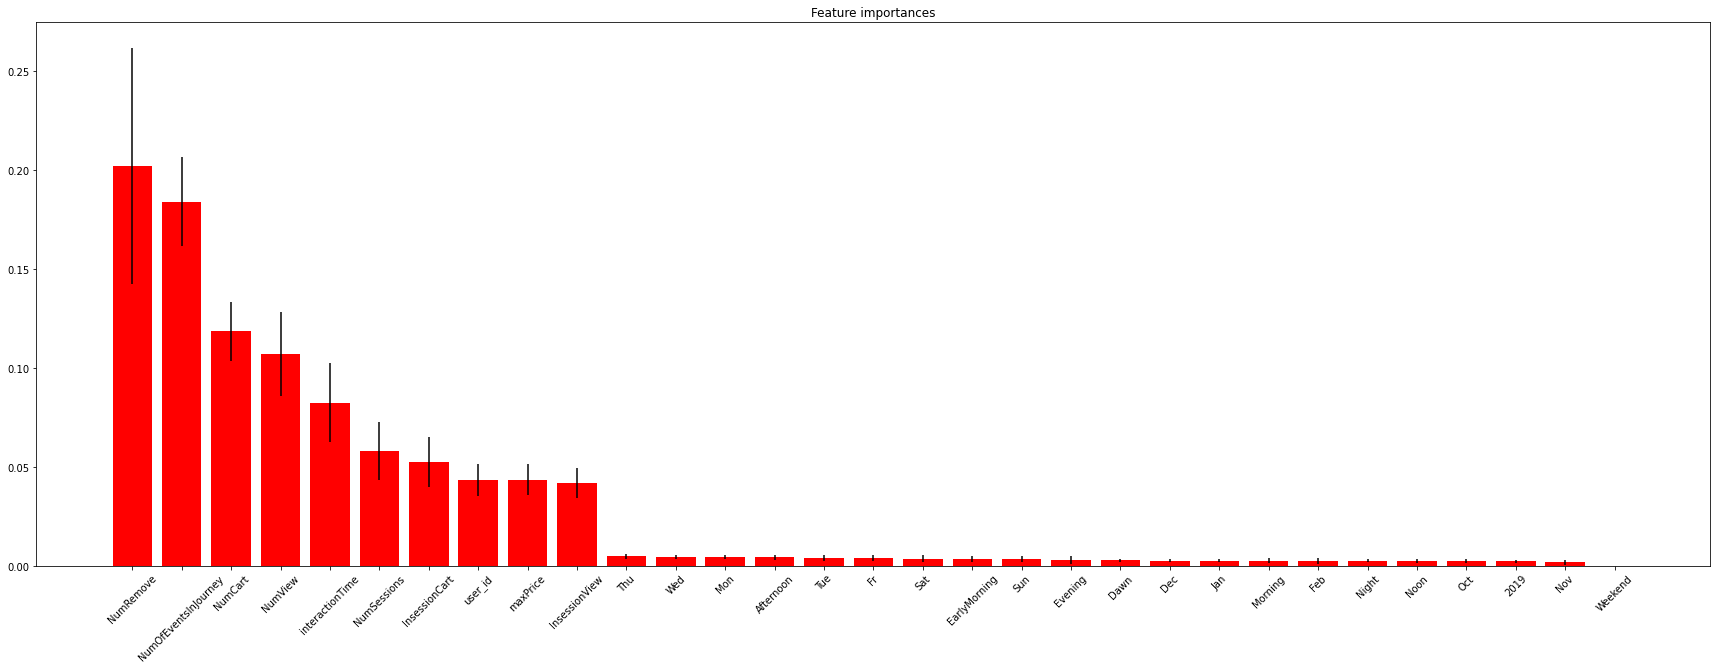

In [39]:
# Rank Features with random Forest, GINI Index measure
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(selected_columns[indices],importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(rotation = 45)
plt.show()


## Thus features numRemove, numEventsJourney are the top two rated features that can be used to visualize. Let's set up a convenience function for this purpose.

Note that `X`, `y`, and `yhat` must be NumPy arrays for this function to work

In [50]:
# This function visualizes the classification output on scatter plot
# Feature 1 (Interaction Time is used to observe the impact of low ranked feature)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc11=np.where((y>0) & (yhat>0),1,0) #TP
    loc00=np.where((y==0) & (yhat==0),1,0) #TN
    loc10=np.where((y>0) & (yhat==0),1,0) #FN
    loc01=np.where((y==0) & (yhat>0),1,0) #FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o', label='TN')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o',label='FN')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^', label='TP')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^',label='FP')
    ax.set_xlabel('NumRemove')
    ax.set_ylabel('NumEvents_in_Journey')
    ax.set_zlabel('InteractionTime')
    ax.legend()
    plt.title(title)
    plt.show()

# Task 2. Fit a linear model. Pick from SVM, LR. Report results
Ensure each model is the fitted with the best hyperparameters. That includes mitigating the effects of any class imbalances.

### Import models, metrics, and convenience functions

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### Instantiate, train, and predict with the model

Remember to use the test data when making and evaluating the predictions

In [42]:
regb = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
reg_predb = regb.predict(X_test)

### Evaluate the predictions

Accuracy = 0.7410533333333333, Precision = 0.3122313260094794, Recall = 0.923695652173913, F1-score = 0.46670511025070716
Confusion Matrix is:
[[47081 18719]
 [  702  8498]]


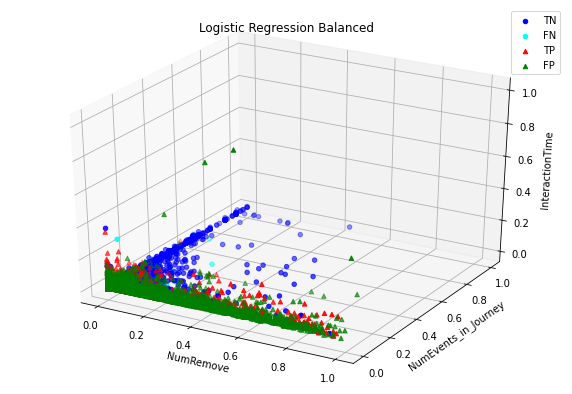

In [51]:

cmlog = confusion_matrix(y_test, reg_predb)
acc   = accuracy(y_test, reg_predb)
rec   = recall(y_test, reg_predb)
prec  = precision(y_test, reg_predb)
f1    = f1_score(y_test, reg_predb)

# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmlog)
visualize_scatter_plot(X_test,y_test,reg_predb,'Logistic Regression Balanced')
#No improvement

### Instantiate and train the model

In [46]:
# Next Run SVM with class weight balanced
svmm = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-3,class_weight='balanced'))
svmm.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', random_state=0,
                           tol=0.001))])

### Generate and evaluate predictions

Accuracy = 0.8888266666666667, Precision = 0.9988425925925926, Recall = 0.09380434782608696, F1-score = 0.17150238473767884
Confusion Matrix is:
[[65799     1]
 [ 8337   863]]


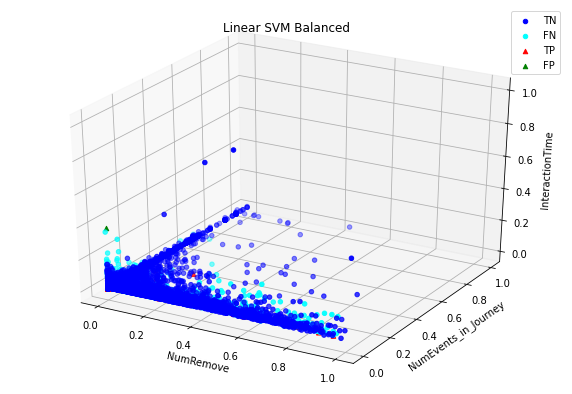

In [52]:
svm_predb = svmm.predict(X_test)
cms  = confusion_matrix(y_test, svm_predb)
acc  = accuracy(y_test, svm_predb)
rec  = recall(y_test, svm_predb)
prec = precision(y_test, svm_predb)
f1   = f1_score(y_test, svm_predb)
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cms)
visualize_scatter_plot(X_test,y_test,svm_predb,'Linear SVM Balanced')

## Task 3: Fit a Non-Linear Classifier,such as GradientBoosting to evaluate if non-linear is the way to go!

### Gradient Boosted Trees

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_model = GradientBoostingClassifier(random_state=1)
gbt_model.fit(X_train, y_train)
gbt_pred = gbt_model.predict(X_test)


Accuracy = 0.9142666666666667, Precision = 0.9139270771069934, Recall = 0.3323913043478261, F1-score = 0.4874860513311015
Confusion Matrix is:
[[65512   288]
 [ 6142  3058]]


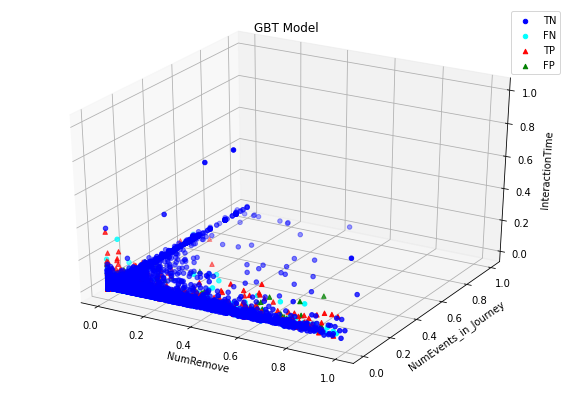

In [54]:

cmgbt = confusion_matrix(y_test, gbt_pred)
acc  = accuracy(y_test, gbt_pred)
rec  = recall(y_test, gbt_pred)
prec = precision(y_test, gbt_pred)
f1   = f1_score(y_test, gbt_pred)

# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmgbt)
visualize_scatter_plot(X_test,y_test,gbt_pred,'GBT Model')

## Task 4: Analyze importace of data sample balancing using Random forest and visualize Decision Tree

### Instantiate, train, predict with, and evaluate an unbalanced random forest classifier

Accuracy = 0.91172, Precision = 0.9760059062384644, Recall = 0.28739130434782606, F1-score = 0.4440339239230834
Confusion Matrix is:
[[65735    65]
 [ 6556  2644]]


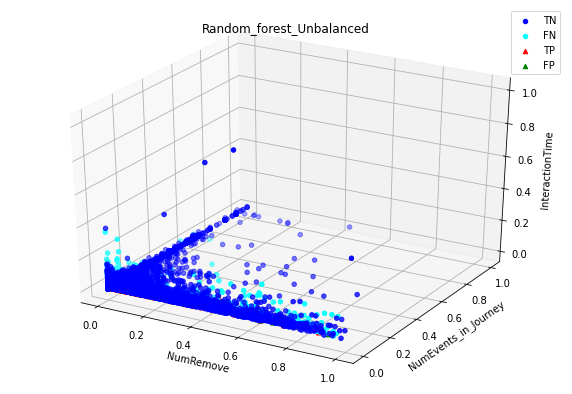

In [55]:
# Instantiate the classifier
# Set the max depth to 5 and the random state to 0
clf = RandomForestClassifier(max_depth=5, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix between the true and predicted test targets
cm   = confusion_matrix(y_test, prediction)
# Compute the model's evaluation metrics
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, prediction, 'Random_forest_Unbalanced')

### Repeat the previous exercise, but this time, incorporate class-balanced penalty weights

Accuracy = 0.9257866666666666, Precision = 0.9223616922361693, Recall = 0.43130434782608695, F1-score = 0.5877647755888016
Confusion Matrix is:
[[65466   334]
 [ 5232  3968]]


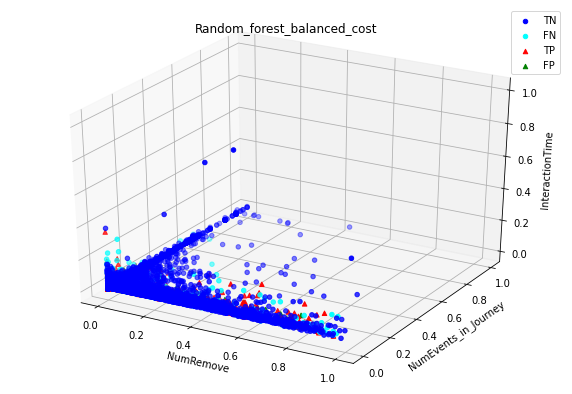

In [56]:

clf = RandomForestClassifier(n_estimators=100, random_state=123, class_weight='balanced')
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, prediction)
# Compute the model's evaluation metrics
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test,y_test,prediction,'Random_forest_balanced_cost')

### Finally, subsample the data so the two classes are equally represented when training the model

DON'T try running this in Colab. You'll get the following error message: `ValueError: object of too small depth for desired array`. It does seem to work when run locally, though.

Accuracy = 0.7856, Precision = 0.35786298653003884, Recall = 0.9414130434782608, F1-score = 0.5185917010957427
Confusion Matrix is:
[[50259 15541]
 [  539  8661]]


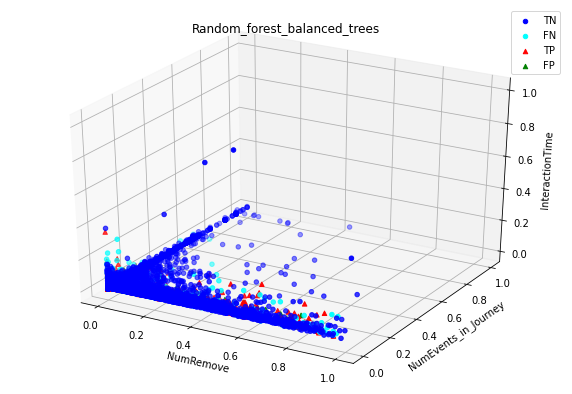

In [57]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate, train, and predict with the classifier
clf = BalancedRandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
predictionBR = clf.predict(X_test)
# Compute the evaluation metrics
cm   = confusion_matrix(y_test, predictionBR)
acc  = accuracy(y_test, predictionBR)
rec  = recall(y_test, predictionBR)
prec = precision(y_test, predictionBR)
f1   = f1_score(y_test, predictionBR)

# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, prediction, 'Random_forest_balanced_trees')

# This Random Forest Classifier with balanced weights is the best model!

In [64]:
cols = np.array((selected_columns)).astype(str)
print(cols)

['user_id' 'NumOfEventsInJourney' 'NumSessions' 'interactionTime'
 'maxPrice' 'NumCart' 'NumView' 'NumRemove' 'InsessionCart'
 'InsessionView' 'Weekend' 'Fr' 'Mon' 'Sat' 'Sun' 'Thu' 'Tue' 'Wed' '2019'
 'Jan' 'Feb' 'Oct' 'Nov' 'Dec' 'Afternoon' 'Dawn' 'EarlyMorning' 'Evening'
 'Morning' 'Night' 'Noon']


In [65]:
print(clf.estimators_[0])

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=209652396)


### Visualize the decision tree

In [66]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = cols,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')